# Intro tutorial

This document explains how to use the package ``twoaxistracking`` for calculating self-shading of two-axis tracking solar collectors.

Import necessary packages:

In [1]:
import pandas as pd
from shapely import geometry
import pvlib
import twoaxistracking

## Definition of collector geometry

The first step is to define the collector geometry. Two geometries have to be created, one which represents the total collector area and one or more geometries representing the active collector area. The geometries can be created using the `shapely` library, e.g.:

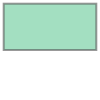

In [2]:
# geometry.box(minx, miny, maxx, maxy)
total_collector_geometry = geometry.box(-1, -0.5, 1, 0.5)

total_collector_geometry

The active collector geometry can be made up of one or more polygons. In this example, the collector has eight active regions:

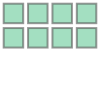

In [3]:
active_collector_geometry = geometry.MultiPolygon([
    geometry.box(-0.95, -0.45, -0.55, -0.05),
    geometry.box(-0.45, -0.45, -0.05, -0.05),
    geometry.box(0.05, -0.45, 0.45, -0.05),
    geometry.box(0.55, -0.45, 0.95, -0.05),
    geometry.box(-0.95, 0.05, -0.55, 0.45),
    geometry.box(-0.45, 0.05, -0.05, 0.45),
    geometry.box(0.05, 0.05, 0.45, 0.45),
    geometry.box(0.55, 0.05, 0.95, 0.45)])

active_collector_geometry

The collector geometries can be defined as any arbitrary polygon using the `shapely` library. However, it is important to note that the `total_collector_geometry` should completely enclose all of the active areas. Circular geometries can be created by: ``shapely.geometry.Point(x_0, y_0).buffer(radius)`` and are approximated as 64 sided polygons.

Note, any unit of length can be used, though it is important to be consistent! Also, the absolute dimensions are generally not of importance, as the GCR parameter scales the distance between collectors according to the total collector area.

<br>

## Specification of collector field layout

Once the collector geometry has been determined, the field layout can be defined. As previously mentioned, the ground cover ratio (GCR), which is the ratio of the collector are to the ground area, determines how close the trackers are arranged.

### Neighbor order
Another required input is the ``neighbor_order``, which determines how many collectors to take into account. For a neighbor order of one the immidiate 8 neighboring collectors are considered, whereas for a neighbor order of two, 24 shading collectors are considered. It is recommended to use atleast a neighbor order of 2, though the computation time increases dramtically with increasing neighbor order.

### Standard vs. custom field layouts
Any regularly-spaced field layout can be specified using the keywords: `aspect ratio`, `offset`, `rotation`, and `gcr`. For a description of the layout parameters, see the paper by [Cumpston and Pye (2014)](https://doi.org/10.1016/j.solener.2014.06.012) or check out the function documentation.


Furthermore, it is possible to choose from four different standard field layouts: `square`, `diagonal`, `hexagon_e_w`, and `hexagon_n_s`. These four layouts corresponds to a fixed set of aspect ratios, offsets, and rotations, and only require the user to specify the GCR.

In the example below, a tracker field is created with a neighbor order of two, a ground cover ratio of 0.2, and a square field layout.

In [4]:
tracker_field = twoaxistracking.TwoAxisTrackerField(
    total_collector_geometry,
    active_collector_geometry,
    neighbor_order=2,
    gcr=0.2,
    layout_type='square'
)

<br>

The field layout can be visualized by the following command:

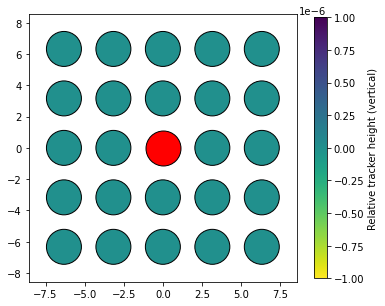

In [5]:
fig = tracker_field.plot_field_layout()    

<br>

## Shading calculation

The final step is to calculate the shaded fraction for the desired solar positions. The typical use case is to simulate shading for a specified period with a fixed interval, e.g., for a yearly simulation with a time-step of 15-minutes.

To calculate the solar position,the discrete time-steps shall be first determined. The below code cell demonstrates how to generate a series of timestamps for one year with a 15-minute interval.

In [6]:
times = pd.date_range(
    start='2019-1-1 00:00',
    end='2019-12-31 23:59',
    freq='15min',
    tz='UTC')

times[:5]  # Show the first 5 timestamps

DatetimeIndex(['2019-01-01 00:00:00+00:00', '2019-01-01 00:15:00+00:00',
               '2019-01-01 00:30:00+00:00', '2019-01-01 00:45:00+00:00',
               '2019-01-01 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='15T')

<br>

It is also important to set the timezone corretly, as it affects the calculation of the solar position. It is recommended to consistently use UTC to avoid mix-ups.

<br>

To calculate the solar position for the timestamps, it is recommended to use the [``pvlib`` library](http://pvlib-python.readthedocs.io/). A convient way to do this is first to create a location object for the location of interest. In this example, a two-axis tracker field in Lendemarke, Denmark is simulated:

In [7]:
location = pvlib.location.Location(latitude=54.9788, longitude=12.2666, altitude=100, name='Lendemarke, Denmark')

The location object can then be used to calculate the solar position for the timestamps:

In [8]:
df = location.get_solarposition(times)

df.head()  # Show the first 5 lines

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2019-01-01 00:00:00+00:00,146.937480,146.937480,-56.937480,-56.937480,19.592191,-3.195874
2019-01-01 00:15:00+00:00,146.108706,146.108706,-56.108706,-56.108706,25.665116,-3.200828
2019-01-01 00:30:00+00:00,145.078546,145.078546,-55.078546,-55.078546,31.493630,-3.205782
2019-01-01 00:45:00+00:00,143.866070,143.866070,-53.866070,-53.866070,37.053369,-3.210734
2019-01-01 01:00:00+00:00,142.491152,142.491152,-52.491152,-52.491152,42.334286,-3.215687


<br>

Now that the solar positions have been determined, the shaded fraction can be calculated by passing the solar positions to the function ``get_shaded_fraction``:

In [9]:
df['shaded_fraction'] = tracker_field.get_shaded_fraction(df['elevation'], df['azimuth'])

## Visualize the shading fraction

Once the shaded fraction has been calculated it can be used for solar power calculations.

As an example, the shaded fraction is shown for one day:

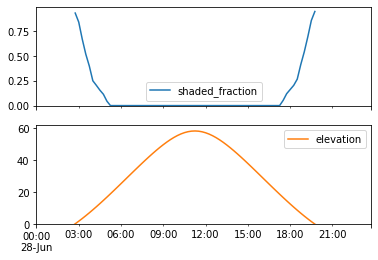

In [10]:
axes = df.loc['2019-06-28':'2019-06-28', ['shaded_fraction', 'elevation']].plot(subplots=True, ylim=[0,None])

Notice how the shaded fraction is zero (unshaded) throughout most of the day, with the exception of some shading in the morning when the solar elevation angle is low.

<br>

Shading is also seasonal dependent, which can be seen from the plot of the average daily shading fraction below:

(0.0, 0.4737615916403633)

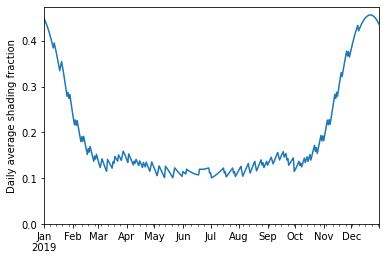

In [11]:
ax = df.loc[df['elevation']>0, 'shaded_fraction'].resample('1d').mean().plot()
ax.set_ylabel('Daily average shading fraction')
ax.set_ylim(0, None)